# Autoencoder Time Series Augmentation

In [ ]:
# Data preprocessing
from scipy.io import arff
import pandas as pd
import numpy as np

# Data augmentation
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import math
from soft_dtw import SoftDTW

# PCA
from sklearn.decomposition import PCA

# Classification and plotting
import AutomatingClassification as automator
import matplotlib.pyplot as plt

## Read in and prepare the data

In [ ]:
def readArffToDf(fileName):
    data = arff.loadarff(fileName)
    return pd.DataFrame(data[0])

In [ ]:
train = readArffToDf('Earthquakes_TRAIN.arff')
test = readArffToDf('Earthquakes_TEST.arff')

In [ ]:
train['target'] = train['target'].astype(int)
test['target'] = test['target'].astype(int)

### Leaving the classes together for time series classification

In [ ]:
trainX = train.drop(columns=['target'])
trainY = train['target']

testX = test.drop(columns=['target'])
testY = test['target']

### Separating out our classes for data augmentation

In [ ]:
trainLabel1 = train [ train['target'] == 1 ]
trainLabel0 = train [ train['target'] == 0 ]

In [ ]:
trainLabel1X = trainLabel1.drop(columns=['target'])
trainLabel1Y = trainLabel1['target']

trainLabel0X = trainLabel0.drop(columns=['target'])
trainLabel0Y = trainLabel0['target']

In [ ]:
trainLabel1X.min()

att1     -0.721463
att2     -0.721463
att3     -0.714995
att4     -0.721463
att5     -0.721463
            ...   
att508   -0.721463
att509   -0.721463
att510   -0.714995
att511   -0.661698
att512   -0.721463
Length: 512, dtype: float64

## Building the model

In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # 512 ==> 9 encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 3)
        )
          
        # 9 ==> 512 decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 512),
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class EarthquakeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def generateSample(self):
      lastDfIndex = len(self.df) - 1
      chosenIndex = random.randint(0, lastDfIndex)
      data = self.df.iloc[chosenIndex].values
      return torch.Tensor(data)

In [ ]:
def setLowerBoundOnArray(arr, lowerBound):
  """
  This function is useful for data augmentation methods.
  We know that values never go below about -0.72 in practice.
  Thus, we can cap the lowest values in our augmentated data.
  """
  arr[arr < lowerBound] = lowerBound

In [ ]:
class DataAugmenter:

  def __init__(self, label):
    """
    The label should equal either 1 or 0. It determines which dataset we grab
    data from.
    """
    if label == 1:
      self.trainDataset = EarthquakeDataset(trainLabel1X)
    elif label == 0:
      self.trainDataset = EarthquakeDataset(trainLabel0X)

    self.model = AE()
    self.input = self.trainDataset.generateSample()


  def trainModel(self, lr, lossFunctionType, verbose=False):

    if lossFunctionType == 'MSE':
      lossFunction = nn.MSELoss()
    elif lossFunctionType == 'SoftDTW':
      lossFunction = SoftDTW(gamma=1.0, normalize=True)
    else:
      raise Exception('The incorrect value was entered.')

    optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

    self.model.train() # Put the model in train mode.
    errorThreshold = random.uniform(0.2, 0.5) # The amount of error is randomized.
    iterCount = 0 # Number of iterations complete.

    while True:
        
        # Compute prediction and loss
        reconstructed = self.model(self.input)
        loss = lossFunction(reconstructed, self.input)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iterCount += 1
        
        # Report loss
        if iterCount % 100 == 0 and verbose:
            iterationStr = "Loss for iteration {}: {:.3f}".format(iterCount, loss)
            print(iterationStr)
            
        if loss <= errorThreshold:
            if verbose:
                errorStr = "Error threshold: {:.3f}".format(errorThreshold)
                print(errorStr)
                lossStr = "Last loss: {:.3f}".format(loss)
                print(lossStr)
            return reconstructed.detach().numpy()


  def generateAugmentedData(self):
    self.model.eval()
    augmented = self.model(self.input)
    self.augmented = augmented.detach().numpy()
    setLowerBoundOnArray(self.augmented, -0.72)

  def plotData(self, fileName=None):
    """
    This function plots the augmented data. It optionally saves the file to 
    'fileName' as long as 'fileName' is not None.
    """
    figure, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,7))

    # Input plot
    input = self.input.detach().numpy()
    ax1.plot(input)
    ax1.set_title('Input data')

    # Augmented plot
    ax2.plot(self.augmented)
    ax2.set_title('Augmented data')

    if fileName is not None:
      plt.savefig(fileName)

## Generate sample augmented data

Loss for iteration 100: 0.988
Loss for iteration 200: 0.976
Loss for iteration 300: 0.964
Loss for iteration 400: 0.952
Loss for iteration 500: 0.940
Loss for iteration 600: 0.926
Loss for iteration 700: 0.912
Loss for iteration 800: 0.897
Loss for iteration 900: 0.880
Loss for iteration 1000: 0.861
Loss for iteration 1100: 0.839
Loss for iteration 1200: 0.814
Loss for iteration 1300: 0.784
Loss for iteration 1400: 0.748
Loss for iteration 1500: 0.702
Loss for iteration 1600: 0.642
Loss for iteration 1700: 0.560
Loss for iteration 1800: 0.445
Loss for iteration 1900: 0.293
Error threshold: 0.233
Last loss: 0.232


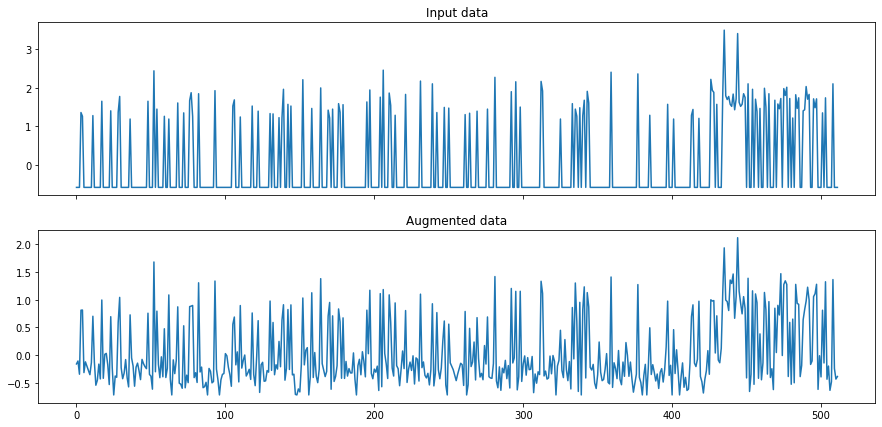

In [ ]:
augmenter = DataAugmenter(label=1)
augmenter.trainModel(0.01, 'MSE', True)
augmenter.generateAugmentedData()
augmenter.plotData(fileName='Class 1 Augmented Data.png')

Loss for iteration 100: 0.981
Loss for iteration 200: 0.966
Loss for iteration 300: 0.951
Loss for iteration 400: 0.934
Loss for iteration 500: 0.915
Loss for iteration 600: 0.893
Loss for iteration 700: 0.866
Loss for iteration 800: 0.832
Loss for iteration 900: 0.786
Loss for iteration 1000: 0.720
Loss for iteration 1100: 0.617
Loss for iteration 1200: 0.453
Loss for iteration 1300: 0.245
Error threshold: 0.234
Last loss: 0.233


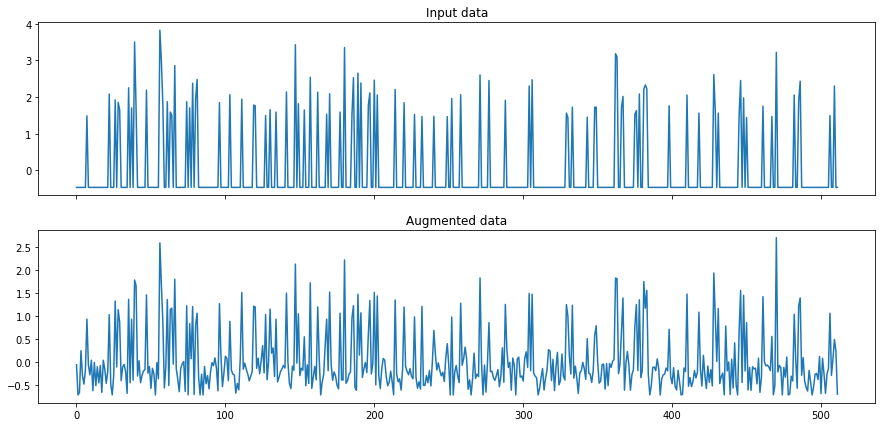

In [ ]:
augmenter = DataAugmenter(label=0)
augmenter.trainModel(0.01, 'MSE', True)
augmenter.generateAugmentedData()
augmenter.plotData(fileName='Class 0 Augmented Data Autoencoder')

## PCA on augmented data

In [ ]:
def generateAugmentedDataset(nSamples, label):
  augmentedDataList = []
  for i in range(nSamples):
    augmenter = DataAugmenter(label=label)
    augmenter.trainModel(0.03, 'MSE', True)
    augmenter.generateAugmentedData()
    augmented = list(augmenter.augmented)
    augmentedDataList.append(augmented)
  return np.array(augmentedDataList)

In [ ]:
def getPCA(dataset):
  pca = PCA(n_components=2)
  components = pca.fit_transform(dataset)
  c1 = components[:, 0]
  c2 = components[:, 1]
  print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_))
  return c1, c2

In [ ]:
def plotPCA(componentsList, colorList, labelList, fileName=None):
  """
  The componentsList should contain a list of tuples. The tuples will contain
  (component1, component2).

  If the fileName parameter is filled, it will save the file. Otherwise,
  it will not be saved.
  """
  plt.figure(figsize=(15,8))
  plt.title('PCA Scatterplot')
  plt.xlabel('PC1')
  plt.ylabel('PC2')

  for i in range(len(componentsList)):
    compTuple = componentsList[i]
    c1 = compTuple[0]
    c2 = compTuple[1]
    color = colorList[i]
    label = labelList[i]
    plt.scatter(c1, c2, color=color, label=label)
  plt.legend()

  if fileName is not None:
    plt.savefig(fileName)

In [ ]:
augmented0 = generateAugmentedDataset(len(trainLabel0X), 0)
augmented1 = generateAugmentedDataset(len(trainLabel1X), 1)

Loss for iteration 100: 0.957
Loss for iteration 200: 0.911
Loss for iteration 300: 0.841
Loss for iteration 400: 0.690
Error threshold: 0.491
Last loss: 0.491
Loss for iteration 100: 0.966
Loss for iteration 200: 0.924
Loss for iteration 300: 0.870
Loss for iteration 400: 0.784
Loss for iteration 500: 0.605
Error threshold: 0.401
Last loss: 0.398
Loss for iteration 100: 0.960
Loss for iteration 200: 0.918
Loss for iteration 300: 0.859
Loss for iteration 400: 0.755
Loss for iteration 500: 0.490
Error threshold: 0.485
Last loss: 0.481
Loss for iteration 100: 0.953
Loss for iteration 200: 0.891
Loss for iteration 300: 0.746
Error threshold: 0.385
Last loss: 0.378
Loss for iteration 100: 0.956
Loss for iteration 200: 0.907
Loss for iteration 300: 0.831
Loss for iteration 400: 0.659
Error threshold: 0.473
Last loss: 0.470
Loss for iteration 100: 0.954
Loss for iteration 200: 0.907
Loss for iteration 300: 0.838
Loss for iteration 400: 0.699
Loss for iteration 500: 0.295
Error threshold: 0.2

Explained variance ratio: [0.01127018 0.01108194]
Explained variance ratio: [0.03180913 0.02862599]
Explained variance ratio: [0.0202098  0.01878974]
Explained variance ratio: [0.06760678 0.06160424]


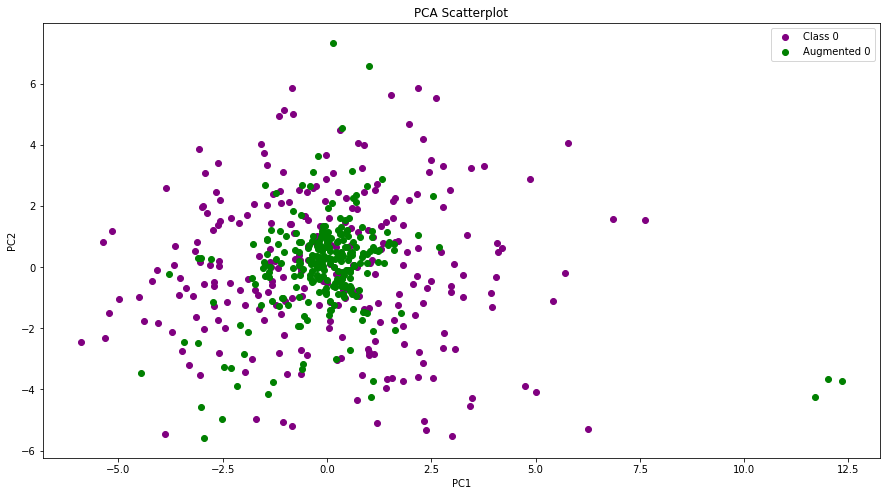

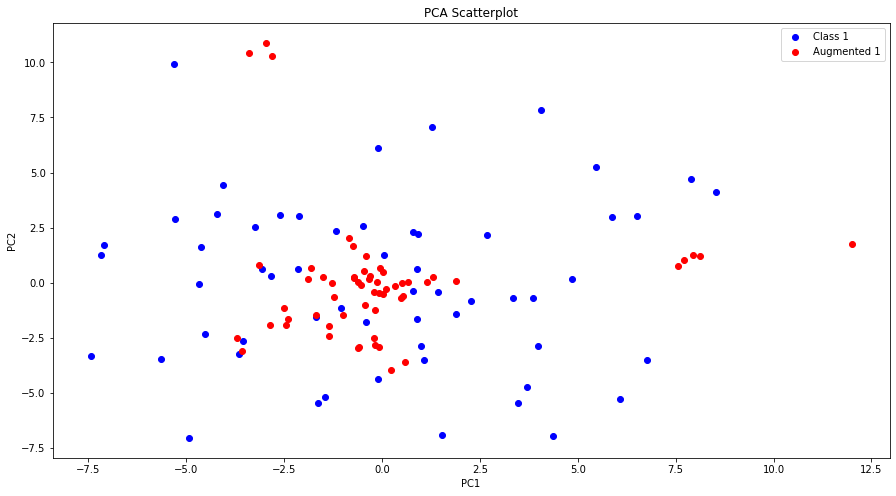

In [ ]:
tuple1 = getPCA(trainLabel0X)
tuple2 = getPCA(trainLabel1X)
tuple3 = getPCA(augmented0)
tuple4 = getPCA(augmented1)

plotPCA([tuple1, tuple3], ['purple', 'green'], ['Class 0', 'Augmented 0'], fileName='Class 0 PCA Autoencoder.png')
plotPCA([tuple2, tuple4], ['blue', 'red'], ['Class 1', 'Augmented 1'], fileName='Class 1 PCA Autoencoder.png')

## Create larger datasets through data augmentation

We can see that there are far fewer datasets of class one. That means we need to generate augmented data for that class.

In [ ]:
n = len(trainLabel0X) - len(trainLabel1X)
augmented1 = generateAugmentedDataset(n, 1)

Loss for iteration 100: 0.967
Loss for iteration 200: 0.927
Loss for iteration 300: 0.877
Loss for iteration 400: 0.801
Loss for iteration 500: 0.650
Loss for iteration 600: 0.271
Error threshold: 0.211
Last loss: 0.211
Loss for iteration 100: 0.955
Loss for iteration 200: 0.908
Loss for iteration 300: 0.839
Loss for iteration 400: 0.694
Error threshold: 0.337
Last loss: 0.333
Loss for iteration 100: 0.959
Loss for iteration 200: 0.911
Loss for iteration 300: 0.835
Loss for iteration 400: 0.652
Error threshold: 0.283
Last loss: 0.280
Loss for iteration 100: 0.959
Loss for iteration 200: 0.906
Loss for iteration 300: 0.822
Loss for iteration 400: 0.620
Error threshold: 0.293
Last loss: 0.289
Loss for iteration 100: 0.972
Loss for iteration 200: 0.932
Loss for iteration 300: 0.878
Loss for iteration 400: 0.776
Loss for iteration 500: 0.417
Error threshold: 0.366
Last loss: 0.362
Loss for iteration 100: 0.951
Loss for iteration 200: 0.886
Loss for iteration 300: 0.737
Error threshold: 0.2

In [ ]:
# Merge the data together.
combinedDf = trainLabel1X.copy()
augmentedDf = pd.DataFrame(augmented1, columns=combinedDf.columns)
combinedDf = pd.concat([combinedDf, augmentedDf], axis=0)
combinedDf['target'] = 1
combinedDf = pd.concat([combinedDf, trainLabel0], axis=0)

# Separate out X and Y.
combinedDfTrainX = combinedDf.drop(columns=['target'])
combinedDfTrainY = combinedDf['target']

In [ ]:
len(combinedDfTrainX)

528

## Evaluate model accuracy on original data

Now fitting logistic regression
Now fitting k-nearest-neighbors
Now fitting random forest classifier


,Hyperparam,Hyperparam val,CV Accuracy,Test Accuracy
Model,,,,
Logistic Regression,C,0.01,0.816779,0.733813
KNN,n_neighbors,21,0.819904,0.748201
Random Forest,n_estimators,-,-,0.748201


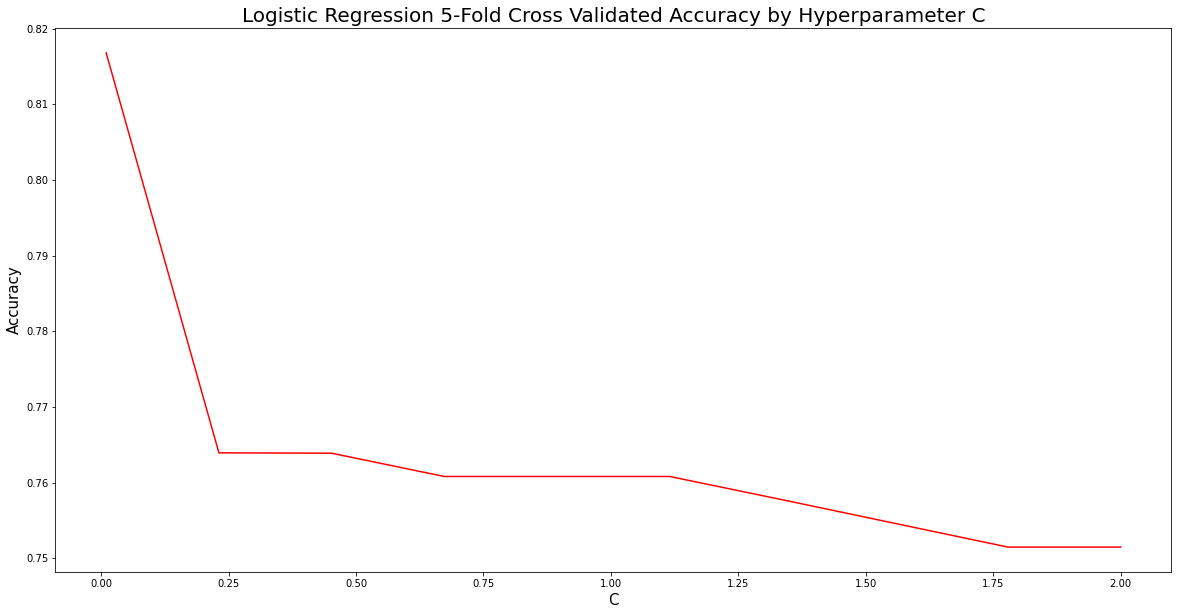

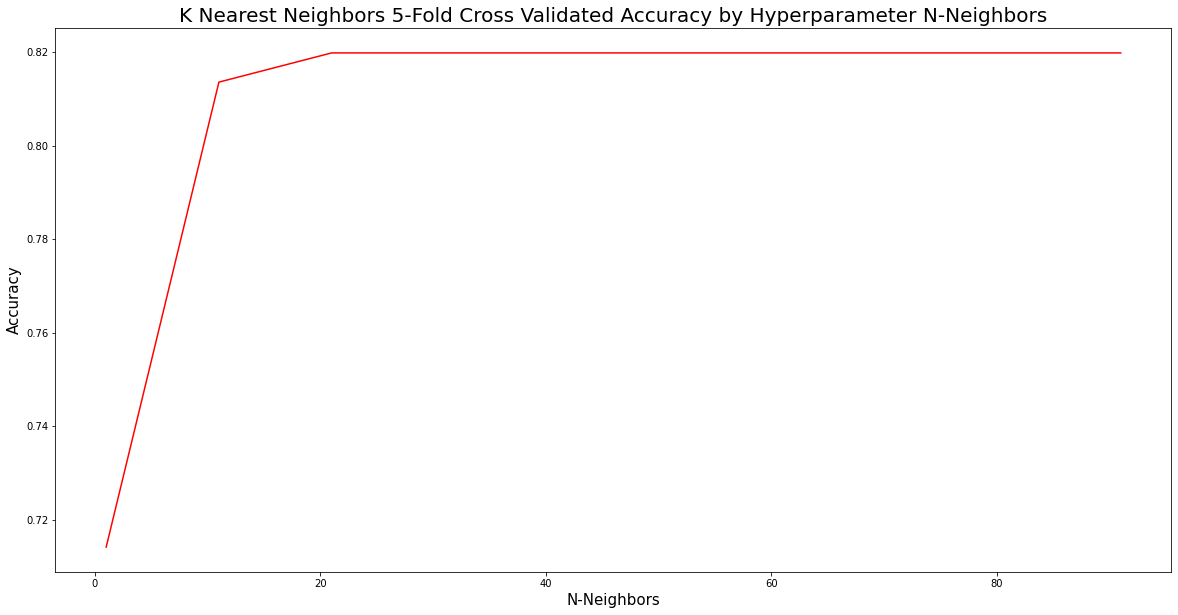

In [ ]:
fitter = automator.AutomaticClassification(trainX, trainY, testX, testY)
reportDf = fitter.main([True, False, True, False, True, False])
reportDf

## Evaluate model accuracy on augmented data

Now fitting logistic regression
Now fitting k-nearest-neighbors
Now fitting random forest classifier


,Hyperparam,Hyperparam val,CV Accuracy,Test Accuracy
Model,,,,
Logistic Regression,C,0.01,0.795328,0.561151
KNN,n_neighbors,1,0.5,0.251799
Random Forest,n_estimators,-,-,0.719424


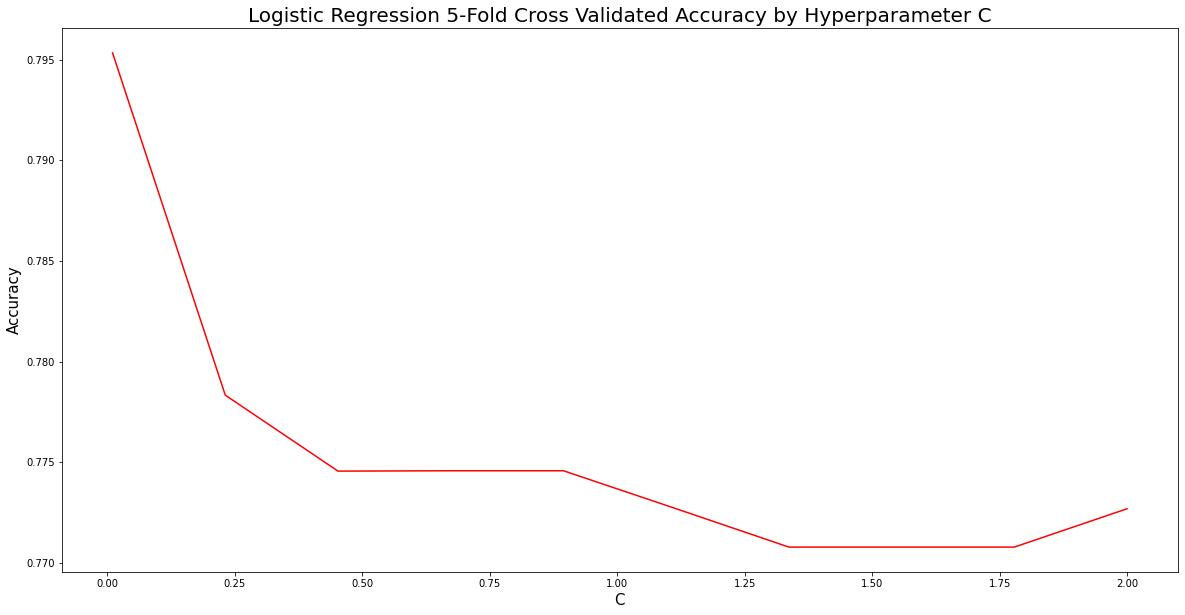

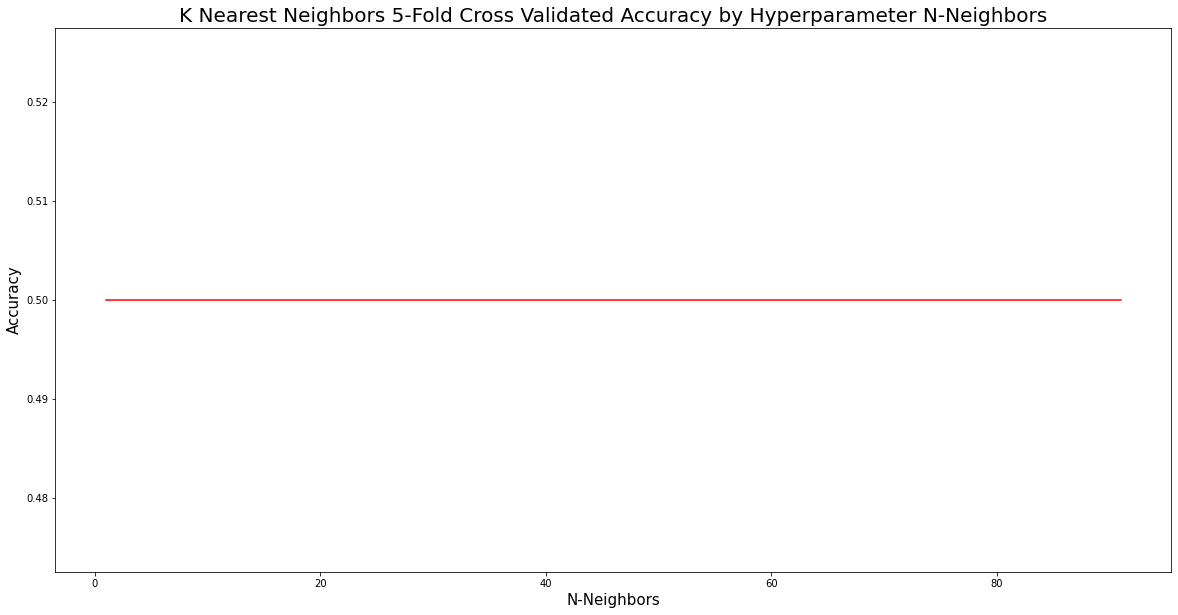

In [ ]:
fitter = automator.AutomaticClassification(combinedDfTrainX, combinedDfTrainY, testX, testY)
reportDf = fitter.main([True, False, True, False, True, False])
reportDf

In [ ]:
# fitterNew = automator.AutomaticClassification(combinedDfTrainX, combinedDfTrainY, testX, testY)
# fitterNew.kNearestNeighbors(2)

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=21)
model.fit(combinedDfTrainX, combinedDfTrainY)
model.score(testX, testY)

0.2517985611510791